In [1]:
import torch
import random
import numpy as np
import torch.nn as nn

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
# %pylab widgetsnbextension

In [2]:
# !pip install ipywidgets
# !jupyter lab nbextension enable --py widgetsnbextension

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('../data/MNIST_data', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('../data/MNIST_data', download=True, train=False)

In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

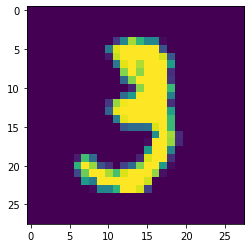

tensor(3)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[10, :, :])
plt.show()
print(y_train[10])

In [10]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [11]:
# добавил дополнительный денс слой обратной пирамидой (div 2)
# скорее для увеличения точности

class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        
        half_hidden = int(n_hidden_neurons/2)

        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, half_hidden) 
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(half_hidden, 10) 

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x


In [12]:
# изменил колв-во нейронов в первом слое
mnist_net = MNISTNet(512)

In [13]:
torch.cuda.is_available()

True

In [14]:
!nvidia-smi

Tue May 19 01:23:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   21C    P8     9W / 265W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   26C    P8    19W / 270W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# для параллельной обработки на GPUS
# if torch.cuda.device_count() > 1:
#     mnist_net = nn.DataParallel(mnist_net, device_ids=[0,1,3])


mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [-0.0209,  0.0038, -0.0286,  ..., -0.0166,  0.0245, -0.0179],
         [ 0.0345, -0.0215, -0.0100,  ...,  0.0320,  0.0304,  0.0316],
         [-0.0284,  0.0013, -0.0103,  ...,  0.0102, -0.0232,  0.0190]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 3.2043e-02,  1.4205e-02,  2.8633e-02, -1.4148e-02, -1.6593e-02,
         -9.9405e-03,  8.1577e-03, -3.2888e-02,  2.7320e-02,  3.5003e-02,
         -2.9972e-02, -3.1398e-02,  3.0973e-02, -7.4480e-03, -1.0189e-02,
          2.1097e-02, -1.8845e-02,  3.3359e-02,  8.1778e-03,  3.1719e-02,
         -3.4391e-02, -1.0967e-02,  1.4626e-02, -6.5218e-03, -1.9927e-02,
          2.0176e-02, -2.8642e-02, -2.7064e-02,  1.3672e-03,  1.9013e-02,
          1.5633e-03, -

In [16]:
loss = torch.nn.CrossEntropyLoss()

# уменьшил шаг спуска - более гладский спуск
# optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-4)
optimizer = torch.optim.RMSprop(mnist_net.parameters(), lr=1.0e-4)

In [17]:
%%time
# уменьшим батч
batch_size = 10
# увеличим кол-во эпох
EPOCHS = 25

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(EPOCHS):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9589, device='cuda:0')
tensor(0.9695, device='cuda:0')
tensor(0.9638, device='cuda:0')
tensor(0.9741, device='cuda:0')
tensor(0.9769, device='cuda:0')
tensor(0.9713, device='cuda:0')
tensor(0.9784, device='cuda:0')
tensor(0.9768, device='cuda:0')
tensor(0.9708, device='cuda:0')
tensor(0.9782, device='cuda:0')
tensor(0.9763, device='cuda:0')
tensor(0.9773, device='cuda:0')
tensor(0.9776, device='cuda:0')
tensor(0.9789, device='cuda:0')
tensor(0.9794, device='cuda:0')
tensor(0.9773, device='cuda:0')
tensor(0.9790, device='cuda:0')
tensor(0.9814, device='cuda:0')
tensor(0.9810, device='cuda:0')
tensor(0.9757, device='cuda:0')
tensor(0.9753, device='cuda:0')
tensor(0.9810, device='cuda:0')
tensor(0.9798, device='cuda:0')
tensor(0.9806, device='cuda:0')
tensor(0.9801, device='cuda:0')
CPU times: user 3min 9s, sys: 2.91 s, total: 3min 12s
Wall time: 3min 11s


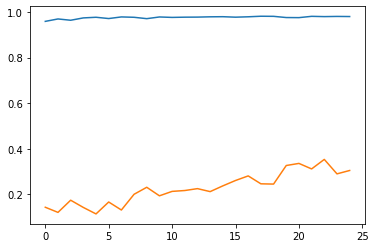

In [18]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history);

In [19]:
idx_loss_min = np.argmin(test_loss_history)
print(f'Min loss = {test_loss_history[idx_loss_min]}, index = {idx_loss_min}, Accuracy = {test_accuracy_history[idx_loss_min]}')

Min loss = 0.11371394246816635, index = 4, Accuracy = 0.9768999814987183


In [20]:
idx_acc_max = np.argmax(test_accuracy_history)
print(f'Max accuracy = {test_accuracy_history[idx_acc_max]}, index = {idx_acc_max}, Loss = {test_loss_history[idx_acc_max]}')

Max accuracy = 0.9813999533653259, index = 17, Loss = 0.24585393071174622


<b>Наблюдение:</b>
<p>
Следующие параметры привели к переобучению
<lo>
    <li> Смена активации слоев на RELU </li>
    <li> Смена оптимизатора на RMSprop и выставление ему шага 1.0e-4 </li>
    <li> Остальные параметры существенного влияния именно на переобучение не имели </li>
</lo>
